# Deep Q-Network (DQN)
---
Implemented a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [1]:
import time
import gymnasium as gym
import random
import torch
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt

from dqn_agent import Agent
%matplotlib inline

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [2]:
env = gym.make("LunarLander-v2")
# env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


### 3. Train the Agent with DQN

Training the agent from scratch.
- Defined a neural network architecture in `model.py` that maps states to action values.
- Defined DQN `Agent` in `dqn_agent.py`.  It samples a batch of experience tuples and uses the local and target Q-networks to compute the loss. Implemented "Experience Replay" and "Fixed Q-targets" concepts from DQN paper in the Agent.

In [3]:
def dqn(env, agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    time_window = deque(maxlen=100)    # last 100 execution times
    eps = eps_start                    # initialize epsilon
    a = 1 - eps
    b = 1 - eps
    for i_episode in range(1, n_episodes+1):
        state, _ = env.reset()
        start_time = time.time()
        score = 0
        for t in range(max_t):
            # get action based on the state.
            action = agent.get_action(state, eps)
            # get next_state, reward, terminated, truncated(bool), and info.
            next_state, reward, done, _, _ = env.step(action)
            # collects experiences (or [S, A, R, S'] tuples) and uses fixed Q-targets
            # to learn (or train) the optimal action-value function.
            # update the hyperparameters first
            agent.update_hyperparameter(a, b)
            _ = agent.step(state, action, reward, next_state, done)
            #if time_taken:
            #    time_window.append(time_taken)

            # reset state to next state
            state = next_state
            score += reward
            if done:
                break
        end_time = time.time()
        time_taken = end_time - start_time
        
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        time_window.append(time_taken)
        
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        a = 1 - eps
        b = 1 - eps
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tAverage Time: {:.2f}'.format(
            i_episode, np.mean(scores_window), time_window[-1]), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tAverage Time: {:.2f}'.format(
                i_episode, np.mean(scores_window), time_window[-1]))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.q_network_local.state_dict(), 'checkpoint.pth')
            break
    return scores


In [ ]:
agent = Agent(
    state_size=env.observation_space.shape[0], 
    action_size=env.action_space.n, 
    seed=42,
)

scores = dqn(env, agent)

Episode 100	Average Score: -167.65	Average Time: 0.19
Episode 200	Average Score: -118.04	Average Time: 0.62
Episode 228	Average Score: -82.35	Average Time: 4.473

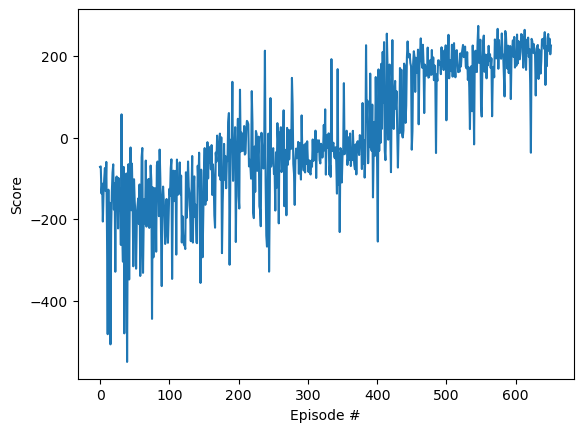

In [27]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [31]:
# Initialize environment
env = gym.make("LunarLander-v2", render_mode="human")

# Initialize agent
agent = Agent(
    state_size=env.observation_space.shape[0], 
    action_size=env.action_space.n, 
    seed=42,
)

# load the weights from file
agent.q_network_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(10):
    state, _ = env.reset()
    for j in range(400):
        action = agent.get_action(state)
        env.render()
        state, reward, done, _, _ = env.step(action)
        if done:
            break 
            
env.close()